# Face Verification and Recognition

This practical explores facial recognition, from inference to synthetic generation and bias analysis.

In the first part, you will start by extracting face embeddings using pre-trained ResNets (18, 34, 101) and evaluate their performance on the LFW benchmark. Next, you will implement a complete training pipeline on CASIA-WebFace with a ResNet 18, exploring different loss functions (cross-entropy, ArcFace, Adaface) .

The second part focuses on the generation of synthetic faces: you will use DCGAN and implement the appropriate loss functions to create synthetic images, then implement and compare the FD and KD metrics to evaluate the quality of the generations between your approach and DDPM.

In the third part, using the code from part 1, you will train an R-18 on DCFace-Call and compare the performance obtained with that of CASIA, on LFW and another benchmark dataset, RFW. Finally, you will conduct a fairness study on the RFW dataset: you will visualize the embeddings, in particular with UMAP, analyze the performance disparities between demographic groups, and propose conclusions on the biases observed in facial recognition systems.


**You need to answer all the [Question] within the 3 parts of the practical**

This practical has been designed to be run on google collab.

**Be carefull to save the weights of your training with the adaface loss** (c.f. last cell of this part)

In [1]:
%%capture
!pip install pytorch_lightning
### relaunch your environment

In [2]:
import argparse
import pytorch_lightning as pl
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import torchvision
# import umap

from tqdm.notebook import tqdm

In [3]:

import torch
import sys
print(f"Python version: {sys.version.split()[0]}")
print(f"PyTorch version: {torch.__version__}")
print(f"Lightnig version: {pl.__version__}")

Python version: 3.12.12
PyTorch version: 2.9.0+cu126
Lightnig version: 2.6.0


Please go to this link https://drive.google.com/drive/folders/1LyVFQHwg-qPFezHTAnMtgX1Khn6ZFsPI?usp=sharing.

Click on the folder name (Centrale) then go to organize and click on add shortcut, go to "all locations" then mydrive then add.

You can either work on collab and directly link your google drive account with the running collab session. Or you can download the data to use it on your own laptop or on Kaggle

In [4]:
# prompt: mount google drive account, create a variable storing the path toward a datafolder within the drive folder then move the img_align_celeba.zip file within this folder to the current dir and unzip it

from google.colab import drive
drive.mount('/content/drive')

data_folder_path = '/content/drive/My Drive/Centrale'

import os

assert os.path.exists(data_folder_path), "The specified path does not exist."

Mounted at /content/drive


### UTILS

In [5]:
# ToTensor makes pixels go in the range [0, 1]
# Antialiasing minimizes distortion artifacts
# Normalize puts pixels value in the range [-1, 1], bcs (x - mean)/std.

image_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((112,112), antialias=True),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [6]:
def set_seed(seed: int):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.

        # May impact performances, but makes CUDA operations deterministic.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


In [7]:
from torchvision import models
from torchvision.models.resnet import conv1x1, conv3x3, _resnet
from typing import Callable, Optional

import torch.nn as nn
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    # By applying the downsampling slightly after, we keep more information, if we do it at the beginning
    # we lose information immediately. This proved to improve performances.

    # Defines the ratio between the bottleneck's inner channels and the output channels.
    expansion: int = 4

    def __init__(
        self,
        # Number of input channels coming into this block from the previous layer
        inplanes: int,
        # Number of channels for the internal layers (3x3 convolution).
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        # If set > 1, allows for ResNeXt
        groups: int = 1,
        # If set > 64, allows for Wide ResNet.
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        # By default is set to BatchNorm2D, but allows for alternative, like SyncBatchNorm for multi GPU training.
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Number of filters for the inner convolutions. In the standard ResNet, planes * (64/64) * 1 -> width = planes.
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        # Reduces the dimensions from inplanes to width, e.g. from 256 to 64
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        # Projects the channels back up to an higher dimension, the output dimension must match the next block's input requirements.
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        # Inplace makes is a memory optimization that avoids creating a new tensor for the ReLU results.
        self.relu = nn.ReLU(inplace=True)
        # Usually a 1x1 convolution with stride and a batchnorm, is done to match dimensions of the input x with the output out
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        # x goes through a reduction of channels (conv1), a spatial convolution (conv2) and an increase of channels (conv3).
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        # No ReLU here, bcs it is done after the input is added.

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    """
    A wrapper for torchvision's ResNet models that outputs a 512-dimensional latent vector.
    """
    def __init__(self, model_name="r_50", normalized=True):
        """
        Initializes the ResNet model.

        Args:
            model_name (str): The name of the ResNet model to use. Options are "r_34", "r_50", "r_101".
            normalized (bool): If True, forward will retunr the vector on the unit hypersphere
        """
        super(ResNet, self).__init__()
        if model_name not in ["r_18","r_34", "r_50", "r_101"]:
            raise ValueError("Unsupported ResNet model name: {}".format(model_name))
        self.normalized = normalized
        if model_name == "r_18":
            self.backbone = models.resnet18()
        elif model_name == "r_34":
            self.backbone = models.resnet34()
        elif model_name == "r_50":
            self.backbone = _resnet(Bottleneck, [3, 4, 6, 3], None, True)
        elif model_name == "r_101":
            self.backbone = _resnet(Bottleneck, [3, 4, 23, 3], None, True)
        else:
            raise ValueError("Unsupported ResNet model name: {}".format(model_name))

        # Get the number of input features for the classifier
        # in_features = self.backbone.fc.in_features

        # Replace the final fully connected layer with a new one that outputs a 512-dim vector
        # This new layer will act as our feature embedding layer.

        # We want the output to have 512 channels, but depending if you use Bottleneck or not, we should change something
        # For the smaller models not using the Bottleneck, the final layer maps the 512 dimensions to the 1000 classes.
        if model_name == "r_34" or model_name == "r_18":
            self.backbone.fc = nn.Identity() ### somehow the nn linear below incerases the performance of the ir 18
        # With the bottleneck we have an expanded output, probably with 2048 channels, we want to reduce it to 512.
        else:
            self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 512)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): The input tensor of shape (N, C, H, W).

        Returns:
            torch.Tensor: The output latent vector of shape (N, 512).
        """
        embs = self.backbone(x)
        if self.normalized:
            # Formula of normalization is v/(norm2(v) + epislon), epsilon is used to not divide by 0.
            norm = torch.norm(embs, p=2, dim=1, keepdim=True) + 1e-6
            embs = embs.div(norm)
            # norm is used in some loss function (like MagFace), to weigh the sample accordingly.
            return embs, norm
        return embs

### FACE Verification inference

In this part, we are going to use and train face recognition (FR) models to perform the face verification task.

FR models are trained on a multi-class (n class) classification task, using datasets containing a set of n people with several images associated to each individual person.

Discarding the classification layer, we then use the latent space of the trained model to determin if any pair of images represents the same person or not.

To do so, a threshold must be found on the latent space's distances to discriminate between positive pairs (same person) and negative (different people).



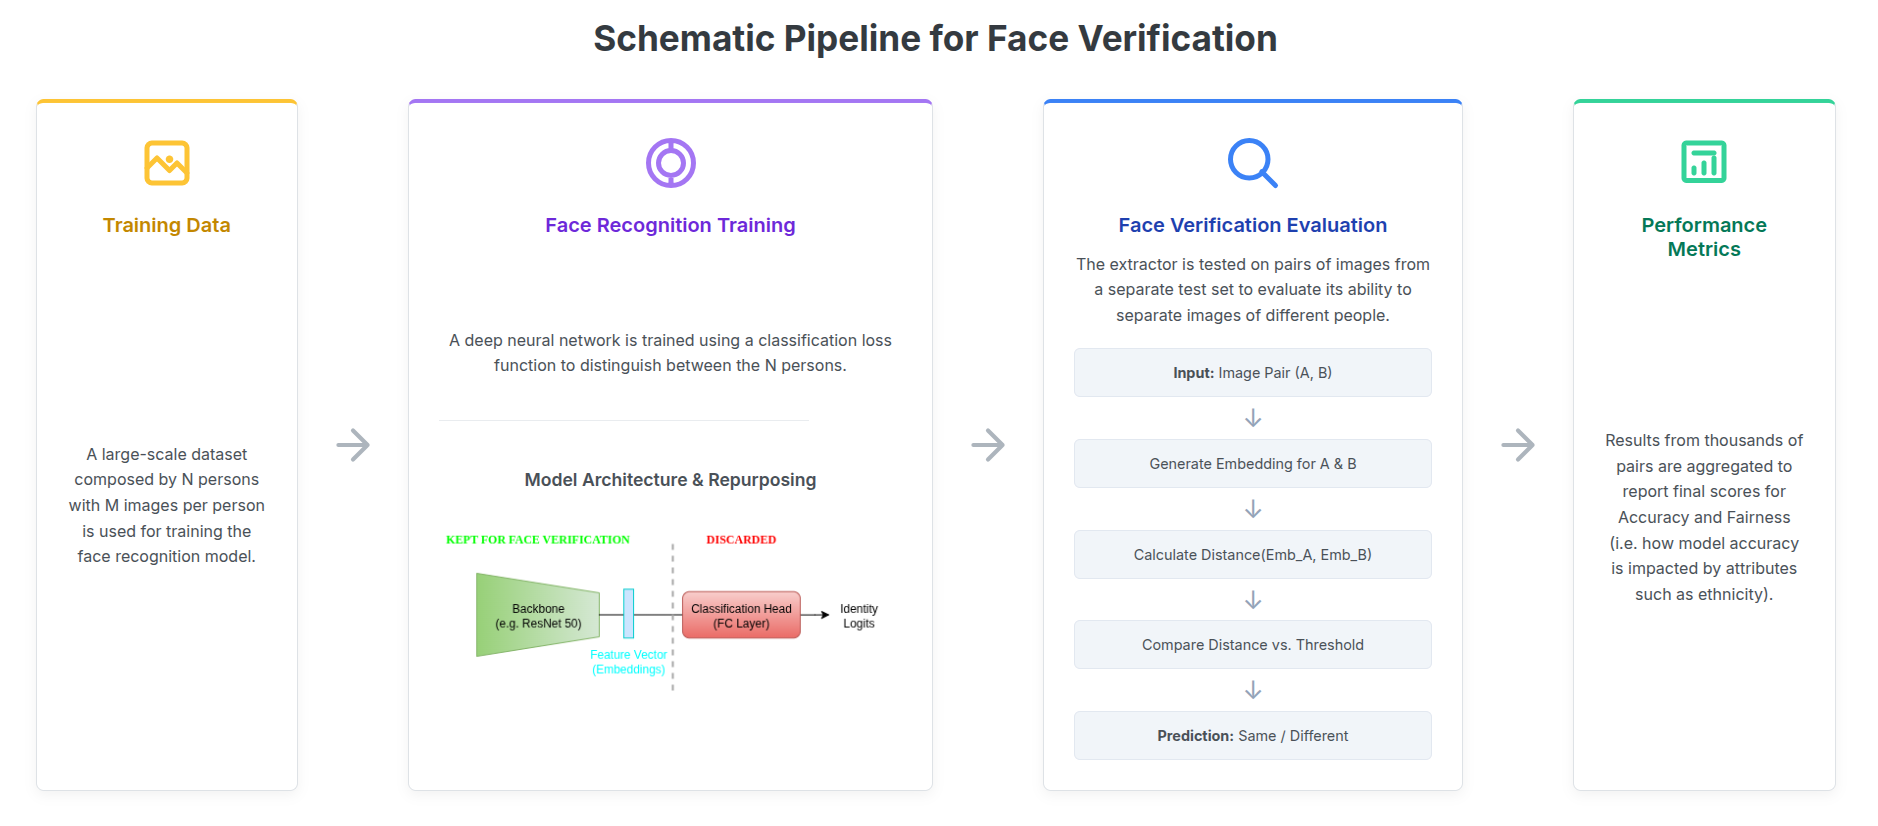

#### Utils

In [8]:
### loading the model weights
def load_model(model_name, weights_path: str):
    model = ResNet(model_name=model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device  == "cpu":
        print("WARNING: You are running on CPU, this will be slow!")
    # map_location is used to not make pytorch crash if the model was trained on multiple gpus. Bcs in the model that information will be saved.
    check_dict = torch.load(weights_path,  map_location=device)
    state_dict = check_dict['state_dict']
    # the first part is about loading, the second part with the head, discards the classification head.
    state_dict = {k.replace('model.', ''): v for k, v in state_dict.items() if "head" not in k}
    # Maybe add strict=False here.
    model.load_state_dict(state_dict)
    return model.to(device)


In [9]:
def get_alias_true_path(alias, imgs_dir):
    dir_name = "_".join(alias.split('_')[:-1])
    file_index = int(alias.split('_')[-1].split(".")[0])
    # Maybe add sorted here.
    dir_content = os.listdir(os.path.join(imgs_dir, dir_name))
    true_file_name = dir_content[file_index]
    return os.path.join(imgs_dir, dir_name, true_file_name), dir_name

def image_pairs_list_to_evaluate(pair_file_path, imgs_dir="LFW/imgs"):
    with open(pair_file_path, 'r') as f:
        # actually the first line is not skipped ??
        lines = f.readlines() # skip the first line
    path_list = []
    labels = []
    for line in tqdm(lines):
        parts = line.split(" ")
        # parts1.stip is safer as newline characters might be kept.
        alias_1, alias_2 = parts[0], parts[1]
        image_path1, label1 = get_alias_true_path(alias_1, imgs_dir)
        image_path2, label2 = get_alias_true_path(alias_2, imgs_dir)
        path_list.append((image_path1, image_path2))
        labels.append((label1, label2))

    return path_list, labels


#### Latent vector inference

The model we are using are trained using the Adaface loss (see https://arxiv.org/abs/2204.00964). We will train a model in this practical also using a "simpler" version of this loss, ArcFace (https://arxiv.org/pdf/1801.07698)

**[Question 1]** Explain why the provided implementation of the Resnets can return the normalized vector and its associated norm. Should you use the normalized version for inference purpose? (you can base your answer on the arcface paper, that you will have to implment later in this practical)

**[Answer 1]**

It can return the normalized vector and its associated norm when the parameter "normalized" of the ResNet is set to True. The normalized vector is needed, because in the ArcFace paper it is explicitly said *"Following [83], [14], [82], [15], we also fix the embedding feature $‖x_i‖$ by $l_2$ normalization and re-scale it to $s$."* . This step is described when starting from the Softmax function the authors of the paper derive their proposed additive angular margin one. Normalizing both the vector and the weights, *"make the prediction only depend on the angle between the feature and the weight."* This allows to focus just on this angle so that the model can be trained to maximize the similarity between images of the same class, by putting them closer, and minimize that of different classes, by putting them further in the hypersphere.

The associated norm is not really used in the ArcFace, but it is in the Adaface loss. There, they discovered that there was a correlation between the norm and the image quality, in particular the Pearson correlation reached $0.5235$ (from a range between -1 and +1). And because in their case, instead of having a fixed margin $m$ for all the records, they wanted to have an adaptive one that depended on the image quality, they chose the norm of $x$ as a proxy for image quality. So the associated norm is used in the calculation of the Adaface loss.

We should use the normalized vector also for inference, because at the end we need to understand whether two faces are of the same individual or not, and we do that using the cosine similarity of the outputs of the ResNet, and given the formula: $cos(\theta) = \frac{ab}{||a||||b||}$ we could avoid calculating the denominator as both norms will be 1, making the calculation a pure dot product. But the main and most important reason we should use the normalized vector is that the neural network was trained to optimize angular distances (as we've seen before), and using the non-normalized vectors would introduce magnitude variations that the model was explicitly trained to ignore.


In [10]:
## Copying evaluation set and model weights
!cp -r "/content/drive/MyDrive/Centrale/LFW" .
! cd LFW && tar -xf imgs.tar

In [11]:
class FVSet(torch.utils.data.Dataset):
    def __init__(self, txt_file, transform, imgs_dir="LFW/imgs", dataset_name = "LFW"):
        self.path_list, self.labels = image_pairs_list_to_evaluate(txt_file, imgs_dir=imgs_dir)
        self.transform = transform
        self.imgs_dir = imgs_dir
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        img_path1, img_path2 = self.path_list[idx]
        label1, label2 = self.labels[idx]

        image_1 = Image.open(img_path1)
        image_2 = Image.open(img_path2)
        image_1 = self.transform(image_1)
        image_2 = self.transform(image_2)
        return image_1, image_2, label1, label2, self.dataset_name
fvSet = FVSet(txt_file="LFW/pairs.txt", transform=image_transform, imgs_dir="LFW/imgs")
fvLoader = torch.utils.data.DataLoader(fvSet, batch_size=128, shuffle=False, num_workers=0)

  0%|          | 0/6000 [00:00<?, ?it/s]

In [23]:
img_1, img_2, lab1, lab2, dn = next(iter(fvLoader))

In [25]:
lab1 == lab2

True

In [26]:
lab1

('Abel_Pacheco',
 'Akhmed_Zakayev',
 'Akhmed_Zakayev',
 'Amber_Tamblyn',
 'Anders_Fogh_Rasmussen',
 'Anders_Fogh_Rasmussen',
 'Angela_Bassett',
 'Angela_Bassett',
 'Angela_Bassett',
 'Ann_Veneman',
 'Ann_Veneman',
 'Ann_Veneman',
 'Anthony_Fauci',
 'Antony_Leung',
 'Antony_Leung',
 'Anwar_Ibrahim',
 'Augusto_Pinochet',
 'Barbara_Brezigar',
 'Benjamin_Netanyahu',
 'Benjamin_Netanyahu',
 'Bernard_Law',
 'Bernard_Law',
 'Bertrand_Bonello',
 'Bill_Frist',
 'Bill_Frist',
 'Bob_Graham',
 'Bob_Graham',
 'Bob_Graham',
 'Bob_Graham',
 'Boris_Becker',
 'Brad_Johnson',
 'Brad_Johnson',
 'Brad_Johnson',
 'Brian_Griese',
 'Candice_Bergen',
 'Candice_Bergen',
 'Carla_Myers',
 'Cathy_Freeman',
 'Chang_Dae-whan',
 'Charles_Grassley',
 'Clare_Short',
 'Clare_Short',
 'Corinne_Coman',
 'Dai_Bachtiar',
 'Dale_Earnhardt_Jr',
 'David_Caruso',
 'Demi_Moore',
 'Dick_Vermeil',
 'Doris_Roberts',
 'Doris_Roberts',
 'Drew_Barrymore',
 'Edmund_Stoiber',
 'Edmund_Stoiber',
 'Edmund_Stoiber',
 'Edmund_Stoiber',
 'E

In [20]:
a[0][0]

tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9765, -0.9765],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9765, -0.9765],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9765, -0.9765]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9843, -0.9843],
         [-1.0000, -1.0000, -1.0000,  ..., -1

**[Question 2]** Fill the code below. Given an input model returned byt the

---

load_model function, and a face verification loader defined as above, the function is supposed to return the L2 distances between each pair of images in the output space of model. issame should store a list of boolean, set to true if the images labels are the same, else set to false.

In [12]:
#### implementing inference
def infer_fv_distances(model, data_loader):
    ## CODE HERE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    distances, issame = [], []

    with torch.no_grad():
      for img_1, img_2, lab_1, lab_2, _ in data_loader:
        emb_img_1 = model(img_1.to(device))[0]
        emb_img_2 = model(img_2.to(device))[0]
        dist_batch = torch.norm(emb_img_1 - emb_img_2, p=2, dim=1)
        distances.extend(dist_batch.cpu().numpy())

        issame.extend((np.array(lab_1) == np.array(lab_2)))

    return np.asarray(distances), np.asarray(issame)

#### Cross Validation threshold inference

**[Question 3]** Fill the code below. Perform crossvalidation to evaluate, on each of 10 folds, optimal thresholds that you will then use to compute the accuracy on the rest of the dataset.  

In [13]:
def get_accuracy_from_threshold(distances, issame, threshold):
    predictions = distances < threshold
    return np.mean(predictions == issame)


def cross_validation_computation(distance, issame, n_folds=10, logs=True):
    """
    Performs cross-validation to compute accuracy and best thresholds.
    Args:
        distance (list or np.array): List of distances between pairs.
        issame (list): List of boolean values indicating if pairs are of the same class.
        n_folds (int): Number of folds for cross-validation.
    Returns:
        tuple: Mean accuracy, standard deviation of accuracy, mean best threshold, standard deviation of best threshold.
    """
    set_seed(42)
    # shuffling distances
    indices = np.arange(len(distance))
    np.random.shuffle(indices)
    distance = distance[indices]
    issame = np.array(issame)[indices]

    fold_size = len(distance) // n_folds
    fold_accs = []
    fold_best_thresholds = []


    for i in range(n_folds):
        start = i * fold_size
        end = (i + 1) * fold_size if i < n_folds - 1 else len(distance)
        ref_distance = distance[start:end]
        ref_issame = issame[start:end]
        best_threshold = None

        ## PUT CODE HERE
        thresholds = np.arange(0, 4.0, 0.01)

        best_acc_ref = -1
        best_threshold = 0

        for t in thresholds:
            predict_issame = ref_distance < t

            acc = np.mean(predict_issame == ref_issame)

            if acc > best_acc_ref:
                best_acc_ref = acc
                best_threshold = t

        # infer fold accuracy on the non training data
        test_distance = np.concatenate((distance[:start], distance[end:]))
        test_issame = np.concatenate((issame[:start], issame[end:]))

        # Compute the true positive rate (TPR) and false positive rate (FPR)
        test_predictions = test_distance < best_threshold
        tp = np.sum(test_predictions & test_issame) # CODE HERE
        tn = np.sum((~test_predictions) & (~test_issame)) # CODE HERE
        fold_acc = (tp + tn) / len(test_issame)
        fold_accs.append(fold_acc)
        fold_best_thresholds.append(best_threshold)
    if logs:
        print("Average accuracy over folds: {:.4f} ± {:.4f}".format(np.mean(fold_accs), np.std(fold_accs)))
        print("Mean Best threshold over folds: {:.4f} ± {:.4f}".format(np.mean(fold_best_thresholds), np.std(fold_best_thresholds)))
    return np.mean(fold_accs), np.std(fold_accs), np.mean(fold_best_thresholds), np.std(fold_best_thresholds)



In [14]:
########
print("evaluating resnet 18")
model = load_model(model_name='r_18', weights_path='/content/drive/MyDrive/Centrale/ModelWeights/last_r18.ckpt')
distances, issame = infer_fv_distances(model, fvLoader)
_ = cross_validation_computation(np.concatenate(distances), issame, n_folds=10)
#####
print("evaluating resnet 34")
model = load_model(model_name='r_34', weights_path='/content/drive/MyDrive/Centrale/ModelWeights/last_r34.ckpt')
distances, issame = infer_fv_distances(model, fvLoader)
_ = cross_validation_computation(np.concatenate(distances), issame, n_folds=10)
########
print("evaluating resnet 50")
model = load_model(model_name='r_50', weights_path='/content/drive/MyDrive/Centrale/ModelWeights/last_r50.ckpt')
distances, issame = infer_fv_distances(model, fvLoader)
_ = cross_validation_computation(np.concatenate(distances), issame, n_folds=10)
########
print("evaluating resnet 101")
model = load_model(model_name='r_101', weights_path='/content/drive/MyDrive/Centrale/ModelWeights/last_r101.ckpt')
distances, issame = infer_fv_distances(model, fvLoader)
_ = cross_validation_computation(np.concatenate(distances), issame, n_folds=10)

evaluating resnet 18


KeyboardInterrupt: 

### Training a model on CASIA
We will now train our own Face recognition model on a famous dataset: CASIA.
Face Recogntion datasets are very often organised as follows:
Images representing the same person are stored in the same folder:


```
dataset_path
|---person_1
        |---imgs1
        |---imgs2
         ....
        ---imgsM
|---person_2
        |---imgs1
        |---imgs2
         ....
        |---imgsM
  ....
|---person_n
        |---imgs1
        |---imgs2
         ....
        |---imgsM
```




In [ ]:
## RUN ONCE
!mkdir casia && cp /content/drive/MyDrive/Centrale/casia/imgs.tar casia/ && cd casia && tar -xf imgs.tar

**[Question 4]** What data augmentation do you deem to be relevant for face recognition (i.e. face images classification)? Write them below, and concatenate them within face_recognition_aug.

Be carefull to not apply your augmentation on all the training samples, but apply them with a certain probability (using RandomApply when necessary)!

In [ ]:
#### Implement here the augmebntations you deem necessary
import random
import torch
from torchvision.transforms.v2 import InterpolationMode, RandomApply, RandomHorizontalFlip, RandomRotation, RandomGrayscale, ColorJitter, ToTensor
from torchvision.transforms.v2 import functional as F
from torchvision.transforms.v2.functional import resize
### Write your code here
face_recognition_aug = transforms.Compose([
    ### CODE HERE
    # Faces are symmetric, so this is safe, it also helps the model to be robust on the faces and not on the backgrounds.
    RandomHorizontalFlip(p=0.5),
    # We want to make the model invariant to lighting conditions by changing brightness and contrast.
    # We also modify saturation, as a picture might have taken from a phone or from a webcam, with big differences in saturation.
    # Lastly we can slightly modify the hue to make the model be more robust to skin tones
    # The reason why we want to be robust to skin tones are two: Skin tone is higly variables, as it depends on lighting, seasons (people are tanned in summer),
    # makeup, camera sensors. The second reason is to make the model avoid relying on race and ethnicity.
    RandomApply([ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.1)], p=0.5)
    # We want the model to be robust to imperfect alignment and head tilts. To do that we chose a very small angle.
    RandomApply([RandomRotation(degrees=10, interpolation=InterpolationMode.BILINEAR)], p=0.2),
    # As for the ColorJitter, it helps the model rely more on structural features of the face rather than the skin tone.
    RandomGrayscale(p=0.1)
    ToTensor(),
    # The model should be robust to images that have faces with sunglasses or masks, this way occlusion can be simulated.
    RandomErasing(p=0.2, scale=(0.02, 0.15))
])

In [ ]:
### We implement here the dataset class that loads the data

class FRSet(torch.utils.data.Dataset):
    def __init__(self, transform, imgs_dir="casia/imgs", logs=False):
        self.imgs_dir = imgs_dir
        self.transform = transform
        self.labels = []
        self.file_path_list = []
        ### list all the files
        for dir in os.listdir(imgs_dir):
            dir_path = os.path.join(imgs_dir, dir)
            if os.path.isdir(dir_path):
                for file in os.listdir(dir_path):
                    file_path = os.path.join(dir_path, file)
                    self.file_path_list.append(file_path)
                    self.labels.append(dir)
        unique_labels = np.unique(self.labels)
        label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
        self.labels = [label_to_index[label] for label in self.labels]

    def __getitem__(self, i):

        file_name = self.file_path_list[i]
        label = self.labels[i]
        image = Image.open(file_name)
        return self.transform(image), label

    def __len__(self):
        return len(self.file_path_list)

In [ ]:

import math

class CrossentropyHead(nn.Module):
    def __init__(self, embedding_size = 512, num_classes = 51332):
        super(CrossentropyHead, self).__init__()
        self.fc = nn.Linear(embedding_size, num_classes)

    def forward(self, embs, norms, label):
        embs = embs * norms
        return self.fc(embs)



**[Question 5]** We will use for training the torch lightning library. This library format the training loops the following way:

    * We define a training module (here ClassificationModule ) that implements training,validation and test functions that will be called while training and corresponds to the training, validation and test batch inner loops.
    * A data module that implement functions called to create the training, validation and test dataloaders

    see: https://lightning.ai/docs/pytorch/stable/

    Please Fill the code below to implemente a training process that perform the classification using the cross-entropy loss, using the SGD optimizer with momentum, and a multi step learning rate scheduler.

In [ ]:
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR

### TRaining Module

class ClassificationModule(pl.LightningModule):
    """
    A LightningModule for a classification task with SGD and a StepLR scheduler.

    Args:
        num_classes (int): Number of target classes.
        learning_rate (float): Base learning rate for the optimizer.
        momentum (float): Momentum factor for SGD.
        weight_decay (float): Weight decay (L2 penalty) for SGD.
    """
    def __init__(self, num_classes=10, embedding_size=512, learning_rate=0.1, momentum=0.9, weight_decay=5e-4, step_lr="12,20,24" ,head_name = "crossentropy"):
        super().__init__()
        # Save hyperparameters like learning_rate to self.hparams.
        # This makes them accessible via self.hparams and logs them automatically.
        self.save_hyperparameters()

        # Define your model
        self.model = ResNet(model_name="r_18", normalized=True)
        if head_name == "crossentropy":
            self.head = CrossentropyHead(embedding_size=embedding_size, num_classes=num_classes)
        elif head_name == "arcface":
            self.head = ArcFace(embedding_size=embedding_size, classnum=num_classes)
        elif head_name == "adaface":
            self.head = AdaFace(embedding_size=embedding_size, classnum=num_classes)
        else:
            raise NotImplementedError


        # Define the loss function
        self.criterion = nn.CrossEntropyLoss()

        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, x):
        """Defines the forward pass of the model."""
        return self.model(x)


    def training_step(self, batch, batch_idx):
        """Defines the logic for a single training step."""
        images, labels = batch
        # Forward pass
        embs, norms = self.forward(images)
        logits = None ## CODE HERE

        # Calculate loss
        loss = self.head(embs, norm, labels) ## CODE HERE
        with torch.no_grad():
            accuracy = ## CODE HERE
        self.log('train_loss', loss.item(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', accuracy.item(), on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx, test_step = False):
        """
        Processes one validation batch.
        """
        with torch.no_grad():
            img1, img2, label1, label2, dataset_name = batch

            emb1, norm1 = self.forward(img1)
            emb2, norm2 = self.forward(img2)

            if self.hparams.head_name == "crossentropy":
                emb1 = emb1 * norm1
                emb2 = emb2 * norm2

            distances = torch.norm(emb1 - emb2, p=2, dim=1)

            issame_labels = torch.tensor([l1 == l2 for l1, l2 in zip(label1, label2)])
            if test_step:
                self.test_step_outputs.append( {
                    'distances': distances.cpu(),
                    'issame': issame_labels.cpu(),
                    'dataset_names': dataset_name  # Keep as a list of strings
                })
            else:
                self.validation_step_outputs.append( {
                    'distances': distances.cpu(),
                    'issame': issame_labels.cpu(),
                    'dataset_names': dataset_name  # Keep as a list of strings
                })
    def on_validation_epoch_end(self):
        """
        Called at the end of the validation epoch.

        Args:
            outputs (list): A list of dictionaries, where each dict is
                            the return value from validation_step.
        """
        print("\n[Validation Epoch End] Aggregating results...")
        outputs = self.validation_step_outputs
        with torch.no_grad():
            aggregated_data = {}

            for batch_output in outputs:
                for dist, issame, name in zip(batch_output['distances'],
                                            batch_output['issame'],
                                            batch_output['dataset_names']):
                    if name not in aggregated_data:
                        aggregated_data[name] = {'distances': [], 'issame': []}
                    aggregated_data[name]['distances'].append(dist.item())
                    aggregated_data[name]['issame'].append(issame.item())

            print(f"Found {len(aggregated_data)} datasets: {list(aggregated_data.keys())}")

            for dataset_name, data in aggregated_data.items():
                distances = data['distances']
                issame = data['issame']

                distances = np.asarray(distances)
                issame = np.asarray(issame)

                print(f"Running CV for {dataset_name}...")

                mean_acc, std_acc, mean_thresh, std_thresh = cross_validation_computation(
                    distance=distances,
                    issame=issame,
                    n_folds=10
                )

                self.log(f'val_acc/{dataset_name}', mean_acc, sync_dist=True)
                self.log(f'val_thresh/{dataset_name}', mean_thresh, sync_dist=True)
                self.log(f'val_acc_std/{dataset_name}', std_acc, sync_dist=True)
                self.log(f'val_thresh_std/{dataset_name}', std_thresh, sync_dist=True)

                print(f"  [Result] {dataset_name}: Acc={mean_acc:.4f} (±{std_acc:.4f}), Thresh={mean_thresh:.4f}")

        self.validation_step_outputs.clear()

        print("[Validation Epoch End] Finished.\n")

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx, test_step=True)
    def on_test_epoch_end(self):
        with torch.no_grad():
            outputs = self.test_step_outputs
            aggregated_data = {}

            for batch_output in outputs:
                for dist, issame, name in zip(batch_output['distances'],
                                            batch_output['issame'],
                                            batch_output['dataset_names']):
                    if name not in aggregated_data:
                        aggregated_data[name] = {'distances': [], 'issame': []}
                    aggregated_data[name]['distances'].append(dist.item())
                    aggregated_data[name]['issame'].append(issame.item())

            print(f"Found {len(aggregated_data)} datasets: {list(aggregated_data.keys())}")

            for dataset_name, data in aggregated_data.items():
                distances = data['distances']
                issame = data['issame']

                print(f"Running CV for {dataset_name}...")

                mean_acc, std_acc, mean_thresh, std_thresh = cross_validation_computation(
                    distance=distances,
                    issame=issame,
                    n_folds=10
                )

                self.log(f'test_acc/{dataset_name}', mean_acc, sync_dist=True)
                self.log(f'test_thresh/{dataset_name}', mean_thresh, sync_dist=True)
                self.log(f'test_acc_std/{dataset_name}', std_acc, sync_dist=True)
                self.log(f'test_thresh_std/{dataset_name}', std_thresh, sync_dist=True)

                print(f"  [Result] {dataset_name}: Acc={mean_acc:.4f} (±{std_acc:.4f}), Thresh={mean_thresh:.4f}")

        self.test_step_outputs.clear()

    def configure_optimizers(self):
        """
        Configures the optimizer (SGD) and learning rate scheduler (MultiStepLR).
        """

        ## CODE HERE

In [ ]:
class FRDataModule(pl.LightningDataModule):
    def __init__(self, imgs_dir, batch_size=128, num_workers=4, eval_path="LFW/imgs", txt_eval_file="LFW/pairs.txt", eval_dataset_name="LFW"):
        """
        Initializes the data module.
        """
        super().__init__()
        self.imgs_dir = imgs_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.eval_path = eval_path
        self.txt_eval_file = txt_eval_file
        self.eval_dataset_name = eval_dataset_name

    def setup(self, stage=None):
        """Sets up the datasets for training and validation."""
        if stage == 'fit' or stage is None:
            self.train_dataset = FRSet(transform=face_recognition_aug, imgs_dir=self.imgs_dir)
            self.val_dataset = FVSet(txt_file=self.txt_eval_file, transform=image_transform, imgs_dir=self.eval_path, dataset_name=self.eval_dataset_name)

    def train_dataloader(self):
        """Returns the training dataloader."""
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )
    def val_dataloader(self):
        """Returns the validation dataloader."""

        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
# Assuming your ClassificationModule and FRDataModule are defined as before

# Configure the callback to save every epoch
checkpoint_callback = ModelCheckpoint(
    every_n_epochs=1,
    save_top_k=-1
)


In [ ]:
### training the model
# Set random seed for reproducibility
set_seed(42)
head_name = "crossentropy"
csv_logger = CSVLogger(save_dir="logs/",
                       name=head_name
)

# Initialize the data module
data_module = FRDataModule(
    imgs_dir="casia/imgs",
    batch_size=512,
    num_workers=4,
    eval_path="LFW/imgs",
    txt_eval_file="LFW/pairs.txt",
    eval_dataset_name="LFW"
)

# Initialize the model
model = ClassificationModule(
    num_classes=10572,  # Adjust based on your dataset
    embedding_size=512,
    learning_rate=0.1,
    momentum=0.9,
    weight_decay=5e-4,
    step_lr="12,20,24",
    head_name=head_name
)


# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=30,
    logger=csv_logger,
    #gpus=1 if torch.cuda.is_available() else 0,
    precision=32 if torch.cuda.is_available() else 32,
    callbacks=[checkpoint_callback],
    fast_dev_run=False # Set to True for a quick test run; set to False for full training

)

# Train the model
trainer.fit(model, datamodule=data_module)

**[Question 6]** Prove theoritically that there is an equivalence between the L2 distance between two vectors and the scalar product between the two vectors where these vectors are unit vector (i.e. The norm L2 is 1).

Give the relationship between the scalar product and the L2 distance.

**[Question 7]** Please implement below the ArcFace head to reproduce the approcah presented in this article (https://arxiv.org/pdf/1801.07698)

In [ ]:
def l2_norm(input,axis=1, safe_guard =False):
    norm = torch.norm(input,2,axis,True) +( ( torch.ones_like(input, requires_grad=False) * 1e-5 if safe_guard else torch.zeros_like(input, requires_grad=False)))
    output = torch.div(input, norm)
    return output

class ArcFace(nn.Module):

    def __init__(self, embedding_size=512, classnum=51332,  s=64., m=0.5):
        super(ArcFace, self).__init__()
        self.classnum = classnum
        self.kernel = nn.Parameter(torch.Tensor(embedding_size,classnum))
        # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m # the margin value, default is 0.5
        self.s = s # scalar value default is 64, see normface https://arxiv.org/abs/1704.06369

        self.eps = 1e-6

    def forward(self, embbedings, norms, label):

        kernel_norm = l2_norm(self.kernel,axis=0)
        cosine = None
        scaled_cosine_m = None
        ## CODE HERE
        return scaled_cosine_m


In [ ]:
### training the model
# Set random seed for reproducibility
set_seed(42)
head_name = "arcface"
csv_logger = CSVLogger(save_dir="logs/",
                       name=head_name
)

# Initialize the data module
data_module = FRDataModule(
    imgs_dir="casia/imgs",
    batch_size=512,
    num_workers=4,
    eval_path="LFW/imgs",
    txt_eval_file="LFW/pairs.txt",
    eval_dataset_name="LFW"
)

# Initialize the model
model = ClassificationModule(
    num_classes=10572,  # Adjust based on your dataset
    embedding_size=512,
    learning_rate=0.1,
    momentum=0.9,
    weight_decay=5e-4,
    step_lr="12,20,24",
    head_name=head_name
)


# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=30,
    logger=csv_logger,
    #gpus=1 if torch.cuda.is_available() else 0,
    precision=32 if torch.cuda.is_available() else 32,
    callbacks=[checkpoint_callback],
    fast_dev_run=False # Set to True for a quick test run; set to False for full training

)

# Train the model
trainer.fit(model, datamodule=data_module)

**[Question 8]** Please implement below the AdaFace head to reproduce the approcah presented in this article https://arxiv.org/abs/2204.00964.

In [ ]:
class AdaFace(nn.Module):
    def __init__(self,
                 embedding_size=512,
                 classnum=70722,
                 m=0.4,
                 h=0.333,
                 s=64.,
                 t_alpha=1.0,
                 ):
        super(AdaFace, self).__init__()
        self.classnum = classnum
        self.kernel = nn.Parameter(torch.Tensor(embedding_size,classnum))

        # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m
        self.eps = 1e-3
        self.h = h
        self.s = s

        # ema prep
        self.t_alpha = t_alpha
        self.register_buffer('t', torch.zeros(1))
        self.register_buffer('batch_mean', torch.ones(1)*(20))
        self.register_buffer('batch_std', torch.ones(1)*100)

        print('\n AdaFace with the following property')
        print('self.m', self.m)
        print('self.h', self.h)
        print('self.s', self.s)
        print('self.t_alpha', self.t_alpha)

    def forward(self, embbedings, norms, label):

        kernel_norm = l2_norm(self.kernel,axis=0)
        cosine = None
        scaled_cosine_m = None
        ## CODE HERE


        return scaled_cosine_m

In [ ]:
### training the model
# Set random seed for reproducibility
set_seed(42)
head_name = "adaface"
csv_logger = CSVLogger(save_dir="logs/",
                       name=head_name
)

# Initialize the data module
data_module = FRDataModule(
    imgs_dir="casia/imgs",
    batch_size=512,
    num_workers=4,
    eval_path="LFW/imgs",
    txt_eval_file="LFW/pairs.txt",
    eval_dataset_name="LFW"
)

# Initialize the model
model = ClassificationModule(
    num_classes=10572,  # Adjust based on your dataset
    embedding_size=512,
    learning_rate=0.1,
    momentum=0.9,
    weight_decay=5e-4,
    step_lr="12,20,24",
    head_name=head_name
)


# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=30,
    logger=csv_logger,
    #gpus=1 if torch.cuda.is_available() else 0,
    precision=32 if torch.cuda.is_available() else 32,
    callbacks=[checkpoint_callback],
    fast_dev_run=False # Set to True for a quick test run; set to False for full training

)

# Train the model
trainer.fit(model, datamodule=data_module)

**[Question 9]** Give your insights about these losses, what are the advantages and drawbacks of each of them? Are the results as expected? If not, why do you think so ?

In [ ]:
### think about downloading the weighhts to reuse it in the next parts of the prcatical !
from google.colab import files
files.download("/content/logs/adaface/version_0/checkpoints/epoch=29-step=28770.ckpt")